## ML for Asset Management - Marcos Lopez Prado 

**Date:** 2025-05-27 

### Section 4 - Optimal Clustering

A clustering problem consists of a set of objects and a set of features associated with those objects. The goal is to separate the objects into groups (called clusters) using the features, where intragroup similarities are maximized, and intergroup similarities are minimized.

Similarites can be deemed using the distance functions we found in Chapter 3.

### 4.2 Proximity Matrix

Consider:
- Data Matrix X, N by F where:
- N is the number of objects
- F is the number of features

We use the F features to compute the proximity between the N objects (an NxN matrix)

This proximity matrix can indicate either similarity (correlation/mutual info) or dissimilarity (a distance metric)

The proximity matrix can be represented as an undirected graph where the weights are a function of the similarity (the more similar, the greater the weight) or dissimilarity (the more dissimilar, the smaller the weight).

Then the clustering problem is equivalent to breaking the graph into connected components (disjoint connected subgraphs), one for each cluster.

When forming the proximity matrix, it is a good idea to standardize the input data, to prevent that one feature’s scale dominates over the rest.


### 4.3 Types of Clustering:

There are two types of clustering:

1. Partitioning - create a disjoint partition of the objects
2. Hierarchical - a nested sequence of partitions 

There are various types of clustering algorithms:

1. Connectivity: This clustering is based on distance connectivity, like hierarchical clustering. 
2. Centroids: Perform vector quantization! See 477 notes. K-means
3. Distribution: Clusters are formed using statistical distributions, e.g., a mixture of Gaussians.
4. Density: These algorithms search for connected dense regions in the data space. Examples include DBSCAN and OPTICS.
5. Subspace: clusters are modeled on two dimensions, features and observations. An example is biclustering, they can help identify similarities in subsets of instruments and time periods simultaneously

If the number of features greatly exceeds the number of observations, the curse of dimensionality can make the clustering problematic.

One solution is to project the data matrix X onto a low-dimensional space, similar to how PCA reduces the number of features. An alternative solution is to project the proximity matrix onto a low-dimensional space, and use it as a new X matrix. Either way, see Chapter 2 to help choose the number of dimensions that are associated with signal not noise

### 4.4 Number of Clusters

When we dont know the number of clusters, we need methods to determine when to stop.

The “elbow method” is a popular technique that stops adding clusters when the marginal percentage of variance explained does not exceed a predefined threshold.

In this section we present one algorithm (ONC) that recovers the number of clusters from a shuffled block-diagonal correlation matrix. 

### 4.4.1 Observation Matrix

If we already have an observation matrix, or the problem doesnt involve a correlation matrix, skip this.

Assume that we have N variables that follow a multivariate Normal distribution characterized by a correlation matrix ρ, where ρ_i,j is the correlation between variables i and j.

If a strong common component is present, it is advisable to remove it by applying the detoning method explained in Chapter 2.

For the purposes of correlation clustering, we can follow at least three approaches:

(a). Circumvent the X (NxF) matrix by directly defining the distance matrix as d_i,j = sqrt(1/2(1-ρ_i,j)), the VI
(b). Use the correlation matrix as X
(b). Derive the X matrix as X_i,j = sqrt(1/2(1-ρ_i,j))

The advantage of options (b) and (c) is that the distance between two variables will be a function of multiple correlation estimates, and not only one, which makes the analysis more robust to the presence of outliers.

In this section we follow option (c). 

The clustering of correlation matrices is peculiar in the sense that the features
match the observations: we try to group observations where the observations themselves are the features (hence the symmetry of X). Matrix X appears to be a distance matrix, but it is not. It is still an observations matrix, on which distances can be evaluated.

For large matrices X, generally it is good practice to reduce its dimension via PCA. 

### 4.4.2 Base Clustering

At this stage, we assume that we have a matrix that expresses our observations in a metric space.

One possibility would be to use the k-means algorithm on our observation matrix. 
While k-means is simple and frequently effective, it does have two notable limitations: 1. random initializaiton, 2. set number of clusters.

Modification for ONC:

Firstly, introduce an objective function so we can find an "optimal K". Choose the silhoutte score, for a given element i and a given clustering, the silhouette coefficient Si is defined as:

    Si = (bi - ai) / max{ai, bi} ; i = 1 ,..., N 

where:
- ai is the average distance between i and all other elements in the same cluster
- bi is the average distance between i and all the elements in the nearest cluster of which i is not a member.

Effectively, this is a measure comparing intracluster distance and intercluster distance. A value Si = 1 means that element i is clustered well, while Si = -1 means that i was clustered poorly.

For a given partition, our measure of clustering quality q is defined as:

    q = E[{Si}] / sqrt(V[{Si}])

where E[{Si}] is the mean of the silhouette coefficients and V[{Si}] is the variance of the silhouette coefficients.

Dealing in expectation allows us to bypass the random initialization problem.

Effectively ONC performs the following operation: 

1. Evaluate the observation matrix; 
2. Perform a double for ... loop. 
    In the first loop, try different k = 2 ,..., N on which to cluster via k-means for one given initialization, and evaluate the quality q for each clustering. 
    The second loop repeats the first loop multiple times, thereby attempting different initializations. 
3. Over these two loops, we select the clustering with the highest q.

In [10]:
# ONC Base Clustering Algorithm

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

#---------------------------------------------------

def clusterKMeansBase(corr0, maxNumClusters=10, n_init=10):
    x = ((1 - corr0.fillna(0)) / 2.)**.5
    silh_best, kmeans_best = pd.Series(), None
    for _ in range(n_init):
        for i in range(2, maxNumClusters + 1):
            kmeans = KMeans(n_clusters=i, n_init=1, random_state=42)
            kmeans = kmeans.fit(x)
            silh = silhouette_samples(x, kmeans.labels_)
            score = np.mean(silh) / np.std(silh)
            if kmeans_best is None or np.isnan(score) or score > np.mean(silh_best) / np.std(silh_best):
                silh_best, kmeans_best = silh, kmeans
    newIdx = np.argsort(kmeans_best.labels_)
    corr1 = corr0.iloc[newIdx, :].iloc[:, newIdx]
    clstrs = {i: corr0.columns[np.where(kmeans_best.labels_ == i)[0]].tolist()
              for i in np.unique(kmeans_best.labels_)}
    silh_series = pd.Series(silh_best, index=x.index)
    return corr1, clstrs, silh_series



### 4.4.3 Higher Level Clustering

The third modifiation deals with clusters of inconsistent quality.

The base clustering may capture the more distinct clusters, while missing the less apparent ones. To address this issue, we evaluate the quality qk of each cluster k = 1, ... , K given the clustering quality scores obtained from the base clustering algorithm.

We then take the average quality q_bar, and find the set of clusters with quality below average, {qk | qk < q_bar, k=1,...,K}. Let us denote as K1 the number of clusters in that set, K1 < K. If the number of clusters to rerun is K1 ≤ 1, then we return the clustering given by the base algorithm. However, if K1 ≥ 2, we rerun the clustering of the items in those K1 clusters, while the rest are considered acceptably clustered.

We form a new (reduced) observations matrix out of the elements that compose the K1 clusters, and rerun the base clustering algorithm on that reduced correlation matrix. Doing so will return a, possibly new, clustering for those elements in K1. To check its efficacy, we compare the average cluster quality before and after reclustering those elements in K1. If the average cluster quality improves, we return the accepted clustering from the base clustering concate- nated with the new clustering for the redone nodes. Otherwise, we return the clustering formed by the base algorithm. 

Implemented below:



In [3]:
# ONC Higher Level Clustering Algorithm:

from sklearn.metrics import silhouette_samples

#---------------------------------------------------
def makeNewOutputs(corr0, clstrs, clstrs2):
    clstrsNew = {}
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs[i])
    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs2[i])

    newIdx = [j for i in clstrsNew for j in clstrsNew[i]]
    corrNew = corr0.loc[newIdx, newIdx]

    x = ((1 - corr0.fillna(0)) / 2.) ** 0.5
    kmeans_labels = np.zeros(len(x.columns))
    for i in clstrsNew.keys():
        idxs = [x.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs] = i

    silhNew = pd.Series(silhouette_samples(x, kmeans_labels), index=x.index)
    return corrNew, clstrsNew, silhNew

#---------------------------------------------------
def clusterKMeansTop(corr0, maxNumClusters=None, n_init=10):
    if maxNumClusters is None:
        maxNumClusters = corr0.shape[1] - 1

    corr1, clstrs, silh = clusterKMeansBase(
        corr0,
        maxNumClusters=min(maxNumClusters, corr0.shape[1] - 1),
        n_init=n_init
    )

    clusterTstats = {
        i: np.mean(silh[clstrs[i]]) / np.std(silh[clstrs[i]])
        for i in clstrs.keys()
    }
    tStatMean = sum(clusterTstats.values()) / len(clusterTstats)

    redoClusters = [
        i for i in clusterTstats.keys() if clusterTstats[i] < tStatMean
    ]

    if len(redoClusters) <= 1:
        return corr1, clstrs, silh
    else:
        keysRedo = [j for i in redoClusters for j in clstrs[i]]
        corrTmp = corr0.loc[keysRedo, keysRedo]
        tStatMean = np.mean([clusterTstats[i] for i in redoClusters])

        corr2, clstrs2, silh2 = clusterKMeansTop(
            corrTmp,
            maxNumClusters=min(maxNumClusters, corrTmp.shape[1] - 1),
            n_init=n_init
        )

        corrNew, clstrsNew, silhNew = makeNewOutputs(
            corr0,
            {i: clstrs[i] for i in clstrs.keys() if i not in redoClusters},
            clstrs2
        )

        newTstatMean = np.mean([
            np.mean(silhNew[clstrsNew[i]]) / np.std(silhNew[clstrsNew[i]])
            for i in clstrsNew.keys()
        ])

        if newTstatMean <= tStatMean:
            return corr1, clstrs, silh
        else:
            return corrNew, clstrsNew, silhNew


### 4.5 Experimental Results:

We now design a Monte Carlo experiment to verify the accuracy of the ONC algorithm introduced earlier: 

1. We create an NxN correlation matrix ρ from random draws with a predefined number of blocks K, where intrablock correlation is high and across-block correlation is low;
2. We shuffle that correlation matrix. 
3. We apply ONC, and verify that the ONC algorithm recovers the blocks we injected.

Generation:

Reduce the problem into partitioning N' = N-K(M-1) into K groups of at least size 1.

(Essentially reserve K x M-1 items, then partition the rest into K groups, and add the M-1 back so each has min size M)

See textbook for full generation steps, implementation seen below:

In [6]:
# ONC Random Correlation Matrix Generation:

import numpy as np
import pandas as pd
from scipy.linalg import block_diag
from sklearn.utils import check_random_state

#---------------------------------------------------
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr[corr < -1], corr[corr > 1] = -1, 1  # numerical error
    return corr

#---------------------------------------------------
def getCovSub(nObs, nCols, sigma, random_state=None):
    # Sub correlation matrix
    rng = check_random_state(random_state)
    if nCols == 1:
        return np.ones((1, 1))
    ar0 = rng.normal(size=(nObs, 1))
    ar0 = np.repeat(ar0, nCols, axis=1)
    ar0 += rng.normal(scale=sigma, size=ar0.shape)
    ar0 = np.cov(ar0, rowvar=False)
    return ar0

#---------------------------------------------------
def getRndBlockCov(nCols, nBlocks, minBlockSize=1, sigma=1., random_state=None):
    # Generate a block random correlation matrix
    rng = check_random_state(random_state)
    parts = rng.choice(
        range(1, nCols - (minBlockSize - 1) * nBlocks),
        nBlocks - 1,
        replace=False
    )
    parts.sort()
    parts = np.append(parts, nCols - (minBlockSize - 1) * nBlocks)
    parts = np.append(parts[0], np.diff(parts)) - 1 + minBlockSize

    cov = None
    for nCols_ in parts:
        cov_ = getCovSub(
            int(max(nCols_ * (nCols_ + 1) / 2., 100)),
            nCols_,
            sigma,
            random_state=rng
        )
        if cov is None:
            cov = cov_.copy()
        else:
            cov = block_diag(cov, cov_)
    return cov

#---------------------------------------------------
def randomBlockCorr(nCols, nBlocks, random_state=None, minBlockSize=1):
    # Form block corr
    rng = check_random_state(random_state)
    cov0 = getRndBlockCov(
        nCols,
        nBlocks,
        minBlockSize=minBlockSize,
        sigma=0.5,
        random_state=rng
    )
    cov1 = getRndBlockCov(
        nCols,
        1,
        minBlockSize=minBlockSize,
        sigma=1.0,
        random_state=rng
    )  # add noise
    cov0+=cov1 
    corr0=cov2corr(cov0) 
    corr0=pd.DataFrame(corr0) 
    return corr0


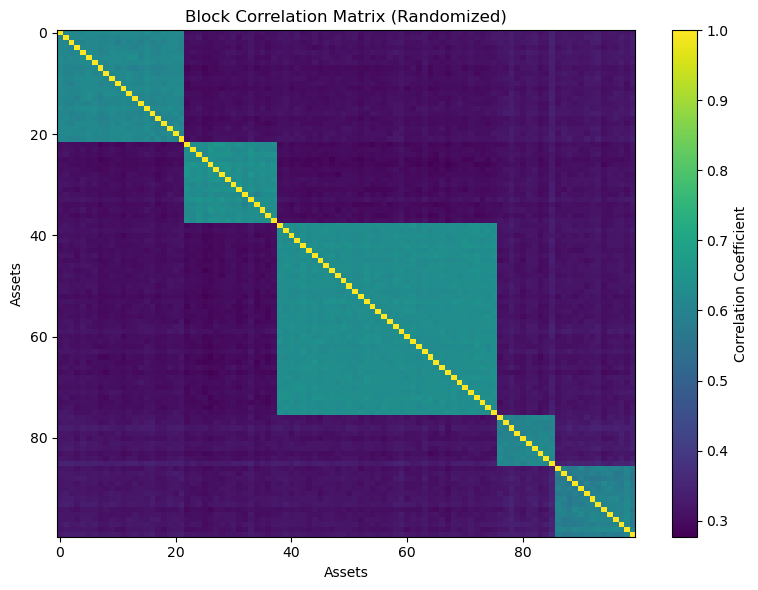

In [8]:
# Example of a random block correlation matrix, before shuffling.

import matplotlib.pyplot as plt

corr_matrix = randomBlockCorr(nCols=100, nBlocks=5, random_state=42, minBlockSize=10)

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Correlation Coefficient')
plt.title("Block Correlation Matrix (Randomized)")
plt.xlabel("Assets")
plt.ylabel("Assets")
plt.grid(False)
plt.tight_layout()
plt.show()

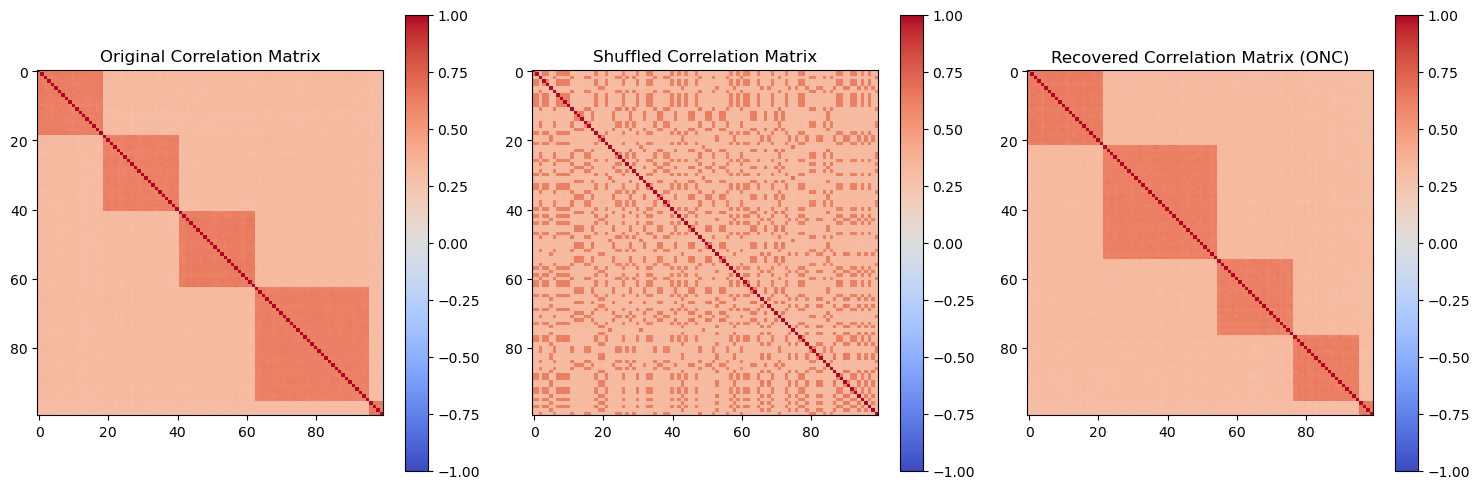

In [11]:
# --- Step 1: Create & Shuffle Correlation Matrix ---
nCols, nBlocks = 100, 5
corr_true = randomBlockCorr(nCols, nBlocks, random_state=42)

# Shuffle
cols = corr_true.columns.tolist()
np.random.seed(1)
np.random.shuffle(cols)
corr_shuffled = corr_true.loc[cols, cols]

# --- Step 2: Apply ONC to recover structure ---
corr_recovered, clusters, silhouette_vals = clusterKMeansBase(corr_shuffled, maxNumClusters=10)

# --- Plot ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(corr_true, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Original Correlation Matrix")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(corr_shuffled, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Shuffled Correlation Matrix")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(corr_recovered, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Recovered Correlation Matrix (ONC)")
plt.colorbar()

plt.tight_layout()
plt.show()

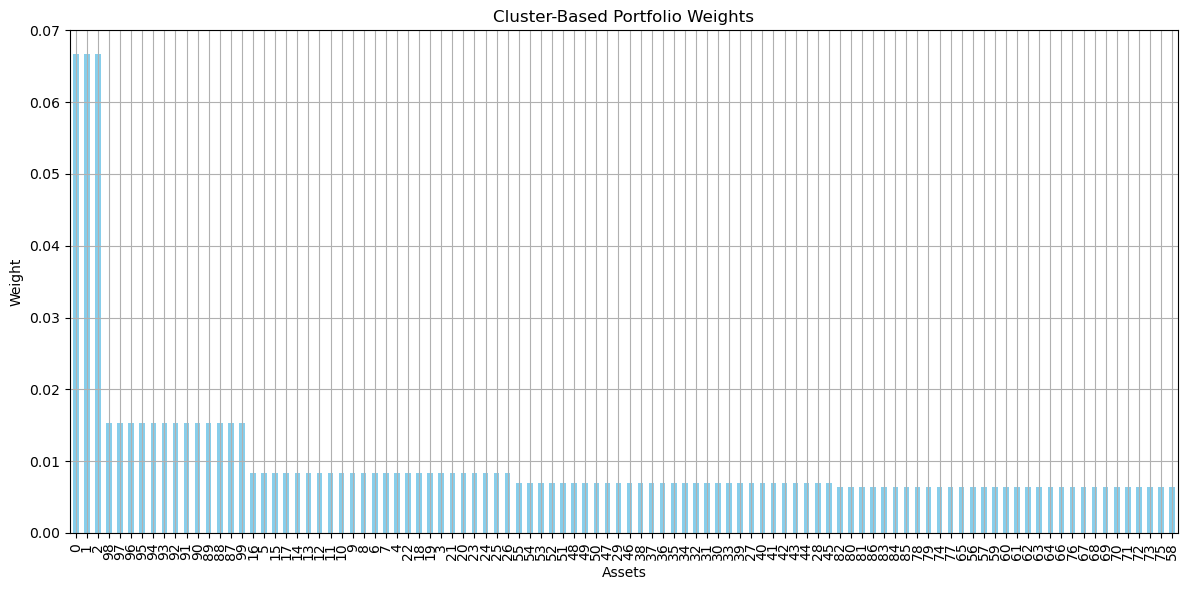

In [14]:
# Cluster-Based Portfolio Allocation with ONC

# Cluster-based Portfolio Weights
def build_cluster_portfolio(clusters, total_assets):
    w = pd.Series(0, index=range(total_assets), dtype=float)
    n_clusters = len(clusters)
    for cluster_assets in clusters.values():
        cluster_weight = 1.0 / n_clusters
        asset_weight = cluster_weight / len(cluster_assets)
        for asset in cluster_assets:
            w[asset] = asset_weight
    return w

np.random.seed(0)
nAssets = 100
nClusters = 5
corr0 = randomBlockCorr(nAssets, nClusters)

# Apply ONC
corr_clustered, clusters, silh = clusterKMeansBase(corr0, maxNumClusters=10, n_init=10)

# Remap asset labels
asset_indices = {name: idx for idx, name in enumerate(corr0.columns)}
mapped_clusters = {
    i: [asset_indices[a] for a in cluster_assets] for i, cluster_assets in clusters.items()
}

# Compute weights
weights = build_cluster_portfolio(mapped_clusters, total_assets=nAssets)
weights.index = corr0.columns  # Restore labels

# ------------------------------
# Plot weights
plt.figure(figsize=(12, 6))
weights.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Cluster-Based Portfolio Weights")
plt.ylabel("Weight")
plt.xlabel("Assets")
plt.grid(True)
plt.tight_layout()
plt.show()
